In [1]:
import numpy as np
#from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'D':0, 'H':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        #self.hiddensCount = 2
       
        
    def readFootBallData(self,filename): 
        df = pd.read_csv(filename)
        df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
        df['HTR'] = df['HTR'].map(self.win_mapping)
        df['FTR'] = df['FTR'].map(self.win_mapping)
        df= df.drop('Referee', 1)
        print(df.shape)
          #self.team = df['HomeTeam'].drop_duplicates()
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
    def formatData(self, X_train ):
        print("start format")
        X_train = X_train.sort_values(by="Date")
        X_train['Date'] = pd.to_numeric(X_train['Date'])/1e9/24/60/60
        
        sys.stdout.flush()
        res = []
        y =[]
        for v in X_train['FTR']:
            y.append(range(3)==v)
        resy=[]
        for i in range(X_train.shape[0]):
            print("\r progress {}".format(i))
            sys.stdout.flush()
            x = X_train.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeTeam = self.getTeam(X_train,homeName)
            awayTeam = self.getTeam(X_train,awayName)
            prevHome = self.previousRecords(homeTeam,x['Date'])
            prevAway = self.previousRecords(awayTeam,x['Date'])
            if prevHome is None or prevAway is None:
               # print("{} skip".format(i))
                continue
           # print("{} has enough sample".format(i))  
            prevHome=prevHome.copy()
            prevAway = prevAway.copy()
            prevHome['HomeTeam']=(prevHome['HomeTeam']==homeName)
            prevHome['AwayTeam']=(prevHome['AwayTeam']==homeName)
            prevAway['HomeTeam']=(prevAway['HomeTeam']==awayName)
            prevAway['AwayTeam']=(prevAway['AwayTeam']==awayName)
            homeDate = prevHome['Date'].values
            awayDate = prevAway['Date'].values
            #homeDate = homeDate.astype('uint64')/1e9/24/60/60
            homeDate = x['Date'] - homeDate 
            #awayDate = awayDate.astype('uint64')/1e9/24/60/60
            awayDate = x['Date'] - awayDate 
            #print(homeDate)
            hv = prevHome.drop('Date',axis=1).values
            av = prevAway.drop('Date',axis=1).values
            hv = np.column_stack([hv, homeDate])
            av = np.column_stack([av,awayDate])
            
            inData = np.ravel(np.array([hv,av]))
            res.append(inData)
            resy.append(y[i])
        
        Xres = np.array(res)
        
       
        X_train_std = Xres
        print("finish")

        return (X_train_std,np.array(resy))
            
    def fit(self,X=None,y=None):
        teams = self.df['HomeTeam'].drop_duplicates()
       
        if X is None or y is None:
            (X, y)=self.formatData(df)
        X_train,X_test_val, y_train, y_test_val =    train_test_split(X,y, test_size=0.4)
        X_val ,X_test,y_val,y_test = train_test_split(X_test_val,y_test_val, test_size=0.5)
        print(X_val)
        
        
     
        print("Start Training")
        self.nn.fit(X_train,y_train)
        print("fisish Training")
        return (X_val ,X_test,y_val,y_test)

    def validate(self, X_val, y_val):
            return self.nn.predict(X_val)
            
            
        
        
    def previousRecords(self,team, date):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < self.recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-self.recentNum:]
    def getH1(self):
        #recent matches (only win/loss/draw)
       
        
       # print (self.df)      
        X  = self.df.sort_values(by="Date")
        y = []
        for v in X['FTR']:
            y.append(range(3)==v)
       # print(y)
        resy=[]
        resx=[]
        print("h1:start format")
        for i in range(X.shape[0]):
            
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            x = X.iloc[i]
            homeName = x['HomeTeam']
            awayName = x['AwayTeam']
            homeTeam = self.getTeam(X,homeName)
            awayTeam = self.getTeam(X,awayName)
            prevHome = self.previousRecords(homeTeam,x['Date'])
            prevAway = self.previousRecords(awayTeam,x['Date'])
            if prevHome is None or prevAway is None:
               # print("{} skip".format(i))
                continue
            prevHomeWin = []
            prevAwayWin = []
            for v in prevHome['FTR']:
                prevHomeWin.append(range(3) == v)
            #print(prevHomeWin)
            for v in prevAway['FTR']:
                prevAwayWin.append(range(3) == v)
            pHHT=(prevHome['HomeTeam']==homeName).values
            pAHT=(prevAway['HomeTeam']==awayName).values
            tempX=[]
            for j in range(pHHT.shape[0]):
                tempX.append(np.append(prevHomeWin[j],pHHT[j]))
                
            for j in range(pAHT.shape[0]):
                tempX.append(np.append(prevAwayWin[j],pAHT[j]))
            resx.append(np.ravel(tempX))
            
            resy.append(y[i])
        print("finish")
        sys.stdout.flush()
        return np.array(resx), np.array(resy)
    def getH2(self):         
       #team based      
        X  = self.df.sort_values(by="Date")
        y = []
        for v in X['FTR']:
            y.append(range(3)==v)
       # print(y)
        resy=[]
        resx=[]
        print("h1:start format")
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        nativeX = X[['HomeTeam','AwayTeam']].values
        #print(X)
        ohe = OneHotEncoder(categorical_features=[0,1])
        res = ohe.fit_transform(nativeX).toarray()
        #print(res)
        return res, np.array(y)


/home/y/Downloads/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:

c = FootballDataHelper(recentNum=4)
c.readFootBallData("E0_1415.csv")
c.readFootBallData("E0.csv")
print(c.teamsMap)
#c.fit()
#c.fit()
#X, y = c.formatData(c.df)
#print(X)
X, y =c.getH2()


(380, 21)
(288, 21)
{'Norwich': 21, 'Tottenham': 18, 'QPR': 3, 'Man United': 2, 'Hull': 16, 'Watford': 22, 'Southampton': 14, 'Swansea': 15, 'Aston Villa': 10, 'Burnley': 9, 'West Brom': 5, 'Stoke': 4, 'Chelsea': 11, 'Arsenal': 0, 'Sunderland': 17, 'Everton': 13, 'Bournemouth': 20, 'West Ham': 6, 'Leicester': 1, 'Newcastle': 8, 'Liverpool': 7, 'Man City': 19, 'Crystal Palace': 12}
h1:start format


In [3]:
print(X)
print(y.shape[0])

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
668


In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.learning_curve import learning_curve
mlp = MLPClassifier(hidden_layer_sizes=(len(c.teamsMap),), activation='logistic', algorithm='l-bfgs', alpha=0, 
              learning_rate_init=0.01,learning_rate='adaptive' ,max_iter=500,early_stopping = True,verbose = 3)
print ("start learning")
sys.stdout.flush()
train_sizes, train_scores, test_scores = learning_curve(estimator=mlp, 
                       X=X, 
                      y=y, 
                      train_sizes=np.linspace(0.1, 1.0, 3), 
                      cv=10,
                     n_jobs=1,verbose=3)
print("finishing")   
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

start learning
[learning_curve] Training set sizes: [ 60 330 601]
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.343284 -   0.3s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.283582 -   1.0s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.313433 -   5.4s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.373134 -   0.2s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.373134 -   1.5s
[CV] no parameters to be set .........................................
[CV] ................ no parameters to be set, score=0.328358 -   2.7s
[CV] no parameters to be set .........................................
[CV] ......

/home/y/Downloads/scikit-learn/sklearn/learning_curve.py:23: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   41.2s finished



finishing


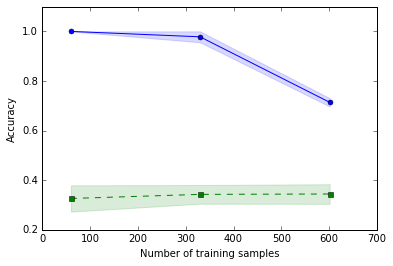

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(train_sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(train_sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(train_sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.show()
plotCurve(train_mean,train_std,test_mean,test_std,train_sizes)


In [6]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate(mlp, X,y):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=10,
                            random_state=1)

    scores = []
    train_scores=[]
    for k, (train, test) in enumerate(kfold):

        mlp.fit(X[train], y[train])
        score = mlp.score(X[test], y[test])
        train_scores.append(mlp.score(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
    return train_scores,scores



In [7]:
def lamda_test(mlp, X, y, lamdas):
    
    train_scores=[]
    test_scores=[]
    for lamda in lamdas:
        mlp.set_params(alpha= lamda)
        print(mlp.get_params())
        train_s, test_s = crossValidate(mlp,X,y)
        train_scores.append(train_s)
        test_scores.append(test_s)
        print("lamda: {}, train: {}, test: {}".format(lamda, 
                    np.mean(train_s), np.mean(test_s)) )
    return np.array(train_scores),np.array(test_scores)

l_range = np.array([0,0.001,0.003,0.01,0.03,0.1])
train_scores,test_scores = lamda_test(mlp,X,y,l_range)
    

{'verbose': 3, 'warm_start': False, 'alpha': 0.0, 'epsilon': 1e-08, 'random_state': None, 'hidden_layer_sizes': (23,), 'activation': 'logistic', 'nesterovs_momentum': True, 'shuffle': True, 'beta_1': 0.9, 'validation_fraction': 0.1, 'learning_rate_init': 0.01, 'momentum': 0.9, 'max_iter': 500, 'early_stopping': True, 'batch_size': 'auto', 'learning_rate': 'adaptive', 'algorithm': 'l-bfgs', 'tol': 0.0001, 'power_t': 0.5, 'beta_2': 0.999}
Fold: 1, Class dist.: [154 258 188], Acc: 0.353
Fold: 2, Class dist.: [154 258 188], Acc: 0.324
Fold: 3, Class dist.: [155 258 188], Acc: 0.299
Fold: 4, Class dist.: [155 258 188], Acc: 0.403
Fold: 5, Class dist.: [155 258 188], Acc: 0.403
Fold: 6, Class dist.: [155 258 188], Acc: 0.284
Fold: 7, Class dist.: [155 258 188], Acc: 0.373
Fold: 8, Class dist.: [155 259 188], Acc: 0.318
Fold: 9, Class dist.: [155 259 188], Acc: 0.379
Fold: 10, Class dist.: [155 259 189], Acc: 0.369
lamda: 0.0, train: 0.7110704960501609, test: 0.35038650842865066
{'verbose': 3

(6,)
(6,)


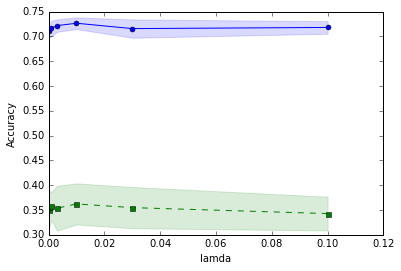

In [8]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_mean.shape)
print(l_range.shape)
#plotCurve(train_mean,train_std,test_mean,test_std,l_range)
plt.plot(l_range, train_mean, 
        color='blue', marker='o', 
        markersize=5, 
        label='training accuracy')
plt.fill_between(l_range, 
              train_mean + train_std,
               train_mean - train_std, alpha=0.15, color='blue')

plt.plot(l_range, test_mean, 
          color='green', linestyle='--', 
          marker='s', markersize=5, 
         label='validation accuracy')
plt.fill_between(l_range, 
                  test_mean + test_std,
                 test_mean - test_std, 
                alpha=0.15, color='green')
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()


In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size =0.3)



In [10]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', algorithm='l-bfgs',
       alpha=0.10000000000000001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(23,), learning_rate='adaptive',
       learning_rate_init=0.01, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=3,
       warm_start=False)

In [11]:
res = mlp.predict_proba(X_test)

In [12]:
for i in range(res.shape[0]):
    print(res[i])
    print(y_test[i])


[ 0.99045872  0.00102725  0.00851403]
[False  True False]
[ 0.7598414   0.02342163  0.21673697]
[False False  True]
[ 0.97666985  0.01017711  0.01315304]
[False  True False]
[ 0.75758249  0.05641823  0.18599928]
[False  True False]
[  9.80752195e-01   1.88013664e-02   4.46438780e-04]
[False  True False]
[  9.77657202e-01   2.20221932e-02   3.20605170e-04]
[False  True False]
[ 0.00895319  0.96668937  0.02435744]
[False  True False]
[ 0.95313245  0.0395061   0.00736145]
[ True False False]
[ 0.01049225  0.98313242  0.00637533]
[False  True False]
[  1.33124527e-03   7.38732662e-05   9.98594881e-01]
[ True False False]
[  9.99316664e-01   3.34117629e-04   3.49218075e-04]
[False  True False]
[  1.34714167e-01   8.37302827e-04   8.64448530e-01]
[False False  True]
[ 0.22122092  0.67117565  0.10760343]
[False False  True]
[  2.10262959e-04   9.99789618e-01   1.18763412e-07]
[False  True False]
[ 0.0190421   0.91425684  0.06670106]
[False  True False]
[ 0.64632714  0.07181304  0.28185982]
[F